<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2023notebooks/2021notebooks/2021_0618CAM_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAM の実習

<div align='right'>
<a href='mailto:educ0233@komazawa-u.ac.jp'>Shin Aasakawa</a>, all rights reserved.<br>
Date: 24/Sep/2021<br/>
Appache 2.0 license<br/>
</div>

* 元論文: https://arxiv.org/abs/1512.04150


In [ ]:
#!pip install japanize_matplotlib

In [ ]:
# source: pytorchCAM.py
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb


# 使用する CNN モデルの名前を指定します。
# 以下の 3 つの中から選んでください。
# CAM はアベレージプーリング層を持つモデルに適用されます。
#model_name = 'squeezenet'
model_name = 'resnet'
#model_name = 'densenet'
if model_name == 'squeezenet':
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_name == 'resnet':
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_name == 'densenet':
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

# ネットワーク構造を表示します。最終畳み込み層の名前に注目してください
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# PyTorch で中間層の出力結果を得るためには，register_hook 関数を使う必要があります
# 以下はそのための変数 `featre_blobs` を定義し，register_forward_hook 関数でその値を取り出す準備をしています。
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
# params[-1] が最終ソフトマックス層，params[-2] がソフトマックス層への重み係数
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    """CAM の実行
    最終直下層 feature_conv と最終層のソフトマックスとの係数とから
    CAM (クラス活性化マッピング) の値を計算して返す
    """
    size_upsample = (256, 256)  # CAM の アンサンプリグ地図 (256x256) を作成
    bz, nc, h, w = feature_conv.shape  # バッチサイズ，チャンネル数，高さ，幅の 4 次元テンソル
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

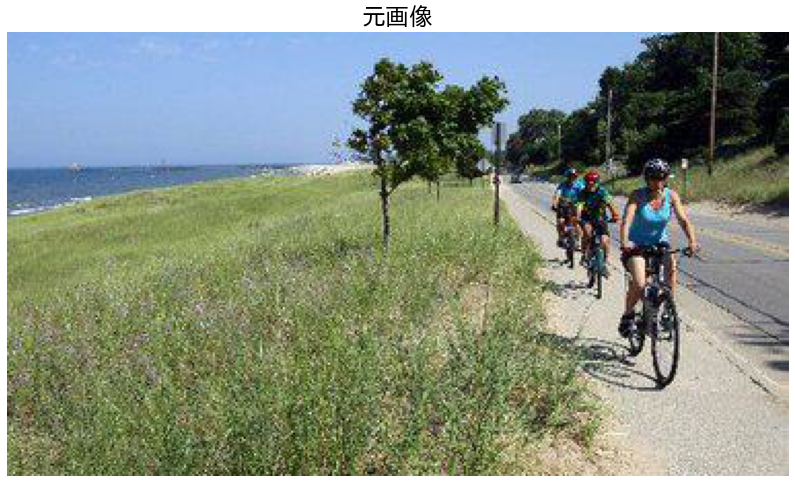

In [ ]:
# サンプル画像を読み込んで表示
import IPython
from PIL import Image as pil_img
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

# ImageNet の正解ラベル読み込み
LABELS_ja_URL= 'https://gist.githubusercontent.com/PonDad/4dcb4b242b9358e524b4ddecbee385e9/raw/dda9454f74aa4fafee991ca8b848c9ab6ae0e732/imagenet_class_index.json'
classes_ja = {int(i):val['ja'] for i, val in enumerate(requests.get(LABELS_ja_URL).json())}
# LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'


# 入力画像
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img = plt.imread('test.jpg')
plt.figure(figsize=(14,14))
plt.title('元画像', fontsize=24)
plt.axis('off'); plt.imshow(img)
# IPython.display.Image(url=IMG_URL) # IPython による画像の画面表示

In [ ]:
# ImageNet のための画像認識モデルへの入力のため，画像のサイズと正規化の定義
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])


img_tensor = preprocess(img_pil) # 前処理
img_variable = Variable(img_tensor.unsqueeze(0))  # PyTorch の variable にする
logit = net(img_variable) # 認識実行。結果を logit に代入

h_x = F.softmax(logit, dim=1).data.squeeze() # ソフトマックス
probs, idx = h_x.sort(0, True) # 認識結果から，カテゴリの確率を得る
probs = probs.numpy()  # PyTorch から numpy 配列へ変換
idx = idx.numpy()

# 予測結果の出力
top_n = 10
print('認識結果')
for i in range(0, top_n):
    print(f'順位{i:2d} {classes_ja[idx[i]]} 確率:{probs[i]:.3f}')

認識結果
順位 0 マウンテンバイク 確率:0.437
順位 1 アルプス 確率:0.131
順位 2 自転車 確率:0.119
順位 3 一輪車 確率:0.108
順位 4 湖畔 確率:0.049
順位 5 海岸 確率:0.031
順位 6 砂州 確率:0.025
順位 7 崖 確率:0.014
順位 8 迷路 確率:0.012
順位 9 谷 確率:0.009


CAM の出力  0:マウンテンバイク


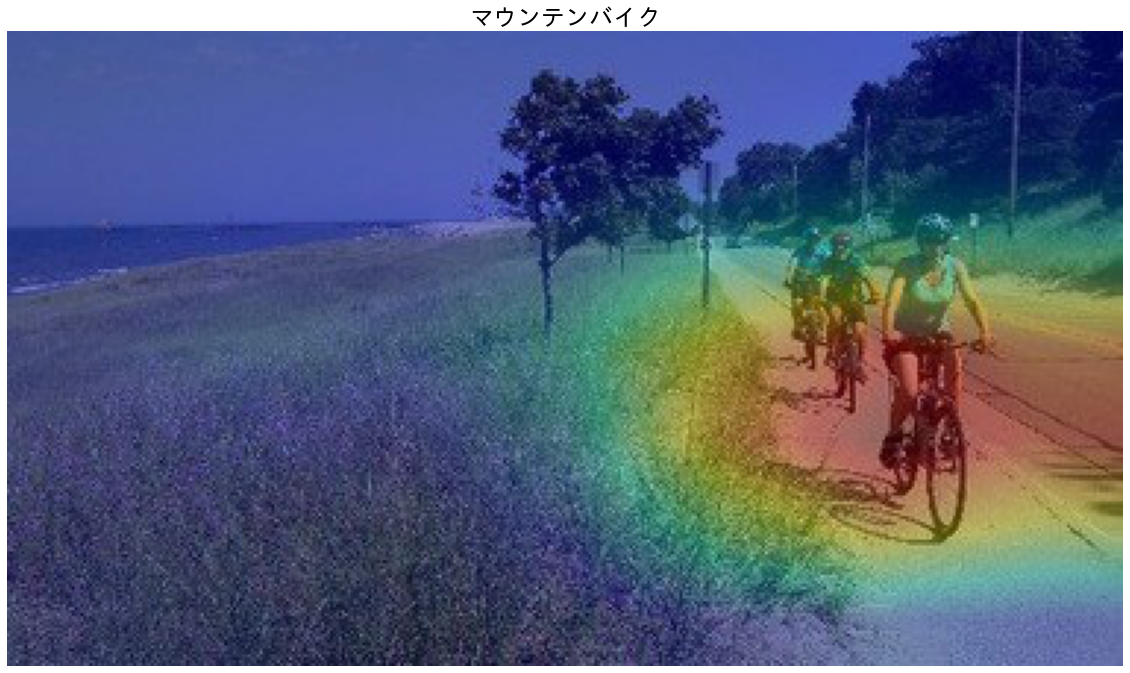

In [ ]:
# トップ 1 に認識されたカテゴリの活性値を元にヒートマップを描画
candidate = 0  # 順位 topn=0
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[candidate]])

# render the CAM and output
print(f'CAM の出力 {candidate:2d}:{classes_ja[idx[candidate]]}')

img = cv2.imread('test.jpg')  # 元画像の読み込み
height, width, _ = img.shape  # 元画像の縦横サイズを取得
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)
#IPython.display.Image('CAM.jpg')
img_ = plt.imread('CAM.jpg')
plt.figure(figsize=(20,20))
plt.title(classes_ja[idx[candidate]], fontsize=24)
plt.axis('off'); plt.imshow(img_)

In [ ]:

height, width, _ = img.shape  # 元画像のサイズ

# 第 top_n 位までの認識結果を表示
top_n = 5
for i in range(top_n):
    CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[i]])
    print(f'CAM の出力 {i:2d}: {classes_ja[idx[i]]}')

    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    img = cv2.imread('test.jpg')
    result = heatmap * 0.3 + img * 0.5
    out_fname = 'CAM'+str(i)+'.jpg'
    #cv2.imwrite('CAM.jpg', result)
    cv2.imwrite(out_fname,  result)
    #IPython.display.Image('CAM.jpg')
    plt.figure(figsize=(10,10))
    plt.title(classes_ja[idx[i]], fontsize=24); plt.axis(False)
    plt.imshow(pil_img.open(out_fname))
    #plt.imshow(pil_img.open('CAM.jpg'))
    #plt.show()

In [ ]:
# まとめて関数化
def CAM5(img_url, n=5):
    response = requests.get(img_url)
    img_pil = Image.open(io.BytesIO(response.content))
    img_pil.save('test.jpg')

    img_tensor = preprocess(img_pil)
    img_variable = Variable(img_tensor.unsqueeze(0))
    logit = net(img_variable)

    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()

    for cand in range(n):
        # generate class activation mapping for the top1 prediction
        CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[cand]])

        # render the CAM and output
        print(f'CAM の出力 {candidate}: {classes_ja[idx[cand]]} 確率:{probs[cand]:.3f}')

        img = cv2.imread('test.jpg')
        height, width, _ = img.shape
        heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + img * 0.5
        cv2.imwrite('CAM.jpg', result)
        #IPython.display.Image('CAM.jpg')
        plt.figure(figsize=(8,8))
        plt.axis(False); plt.title(classes_ja[idx[cand]], fontsize=24)
        plt.imshow(pil_img.open('CAM.jpg')); plt.show()


In [ ]:
# テスト実行
url_img = 'https://raw.githubusercontent.com/komazawa-deep-learning/komazawa-deep-learning.github.io/master/assets/2012AlexNetResult.jpg'
CAM5(url_img)